# K-Armed Bandit Problem

### Introduction
\
\
This Jupyter notebook explores the K-Armed Bandit problem, a fundamental concept in reinforcement learning. The content within this notebook is inspired by and closely aligned with the exercises and examples presented in the renowned book:
\
\
Reinforcement Learning: An Introduction (Second Edition)
by Richard S. Sutton and Andrew G. Barto

### Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import collections

### Define the number of bandits and the reward distribution parameters

In [2]:
# Constants
K = 10 # number of bandits
T = 10000 # number of steps in the simulation

# Generate the means of the reward distributions from a Gaussian distribution with zero mean and unit standard deviation
means = np.random.normal(0, 1, K)

# Define the standard deviations of the reward distributions
# Using a constant value for all standard deviations for simplicity. This could be customized if needed.
stds = [1] * K


### Generate samples for the simulation

In [3]:
#Generate samples for K Bandits and T steps

def generate_samples(K, T, means, stds):
    samples = np.zeros((T, K))
    
    for k, mean, std in zip(range(0, K), means, stds):
        samples[:, k] = np.random.normal(mean, std, T)
        
    return samples

samples = generate_samples(K, T, means, stds)

### Plot the reward distributions

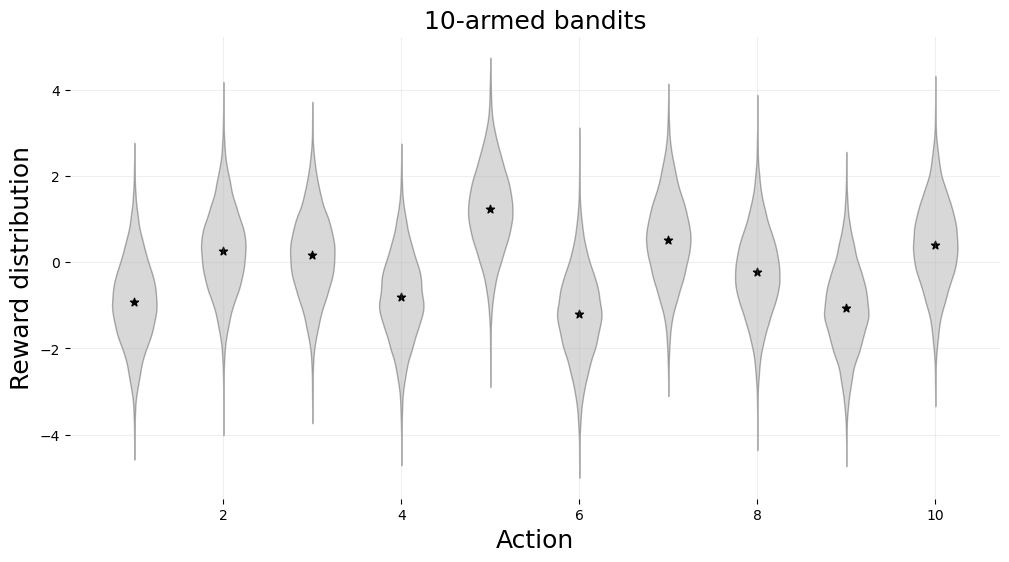

In [4]:
plt.figure(figsize=(12, 6))
ax = plt.gca()
ax.grid(alpha=0.2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

violin_parts = plt.violinplot(samples, showmeans=False, showmedians=False, showextrema=False)

for pc in violin_parts['bodies']:
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')

for i, mean in enumerate(means):
    plt.scatter(i + 1, mean, color='k', marker='*')

plt.title('10-armed bandits', fontsize=18)
plt.xlabel('Action', fontsize=18)
plt.ylabel('Reward distribution', fontsize=18)
plt.show()


### Run the simulation 

Initialize, for $a=1$ to $k$:
$$
\begin{aligned}
& Q(a) \leftarrow 0 \\
& N(a) \leftarrow 0
\end{aligned}
$$

Loop forever:
$$
\begin{aligned}
& A \leftarrow \begin{cases}\arg \max _a Q(a) & \text { with probability } 1-\varepsilon \quad \text { (breaking ties randomly) } \\
\text { a random action } & \text { with probability } \varepsilon\end{cases} \\
& R \leftarrow \text { bandit }(A) \\
& N(A) \leftarrow N(A)+1 \\
& Q(A) \leftarrow Q(A)+\frac{1}{N(A)}[R-Q(A)]
\end{aligned}
$$
\
\
 <span style="font-size:14px;">\* This implementation of the K-Armed Bandit algorithm is based on the description provided in Chapter 2 of Sutton and Barto's book on Reinforcement Learning. </span>


In [5]:
epsilon = 0.1 # epsilon greedy action-value
optimal_action = np.argmax(means)

Q = np.zeros(K)
N = np.zeros(K)
rewards = []
actions = []
optimal_actions = []

for t in range(0, T):
    
    if np.random.uniform(0, 1) <= 1 - epsilon:
        #greedy action selection with random ties
        a = np.argmax(np.random.random(Q.shape) * (Q==Q.max()))
    else:
        a = np.random.randint(0, K)
    
    R = samples[t, a]    
    N[a] += 1
    Q[a] += (R - Q[a]) / (N[a] + 1e-10)
    
    rewards.append(R)
    actions.append(a)
    optimal_actions.append(a == optimal_action)
    

In [6]:
def avg_over_time(data):
    return np.cumsum(data) / np.arange(1, len(data) + 1)

### Average reward over time

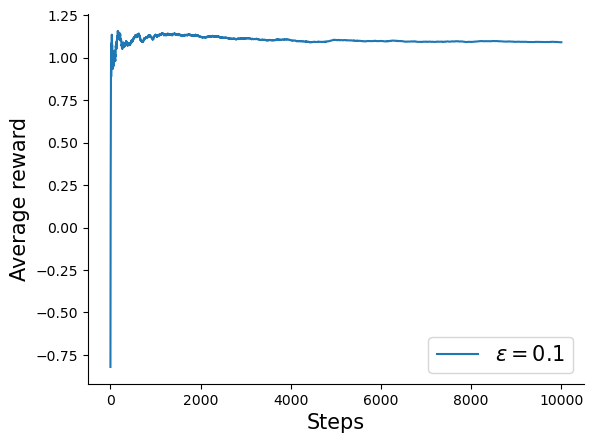

In [7]:
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel("Steps", fontsize=15)
plt.ylabel("Average reward", fontsize=15)
plt.plot(avg_over_time(rewards), label=f"$\epsilon={epsilon}$")
plt.legend(fontsize=15)

### Average optimal action over time

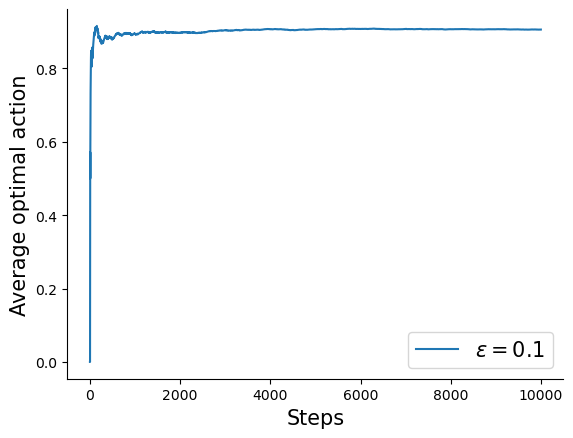

In [8]:
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel("Steps", fontsize=15)
plt.ylabel("Average optimal action", fontsize=15)
plt.plot(avg_over_time(optimal_actions), label=f"$\epsilon={epsilon}$")
plt.legend(fontsize=15)

### Action distribution

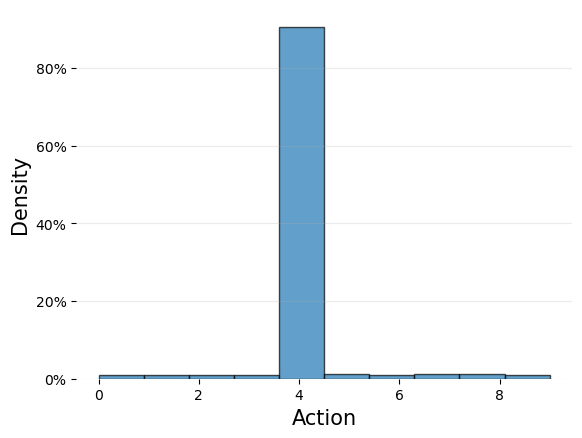

In [9]:
ax = plt.gca()
ax.grid(axis="y", alpha=0.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.xlabel("Action", fontsize=15)
plt.ylabel("Density", fontsize=15)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.hist(actions, weights=np.ones(len(actions)) / len(actions), edgecolor='black', alpha=0.7);


### Final average reward

In [10]:
print("Average Reward: ", np.sum(rewards)/T)

Average Reward:  1.0914726562382027


### Define a class for K-Armed Bandits

In [11]:
class KArmedBandits:
    """
    A class to simulate a K-armed bandit problem, commonly used in reinforcement learning.

    The K-armed bandit problem is a scenario where an agent is presented with K different actions, 
    each associated with a reward determined by a probability distribution. The goal of the agent is 
    to maximize the cumulative reward over a series of actions.

    Attributes:
        epsilon (float): The probability of taking a random action, used in epsilon-greedy action selection.
        K (int): The number of actions (arms) available.
        actions (np.array): An array representing the indices of available actions.
        Q (np.array): An array to store the estimated value of each action.
        N (np.array): An array to track the number of times each action has been selected.
        alpha (float, optional): The step size parameter for updating Q. If None, an incremental formula is used.
        stationary (bool): Indicates whether the reward distributions are stationary (unchanging) or not.
        action_selection (str): The method used to select actions. Options include "e-greedy" and "ucb" (Upper Confidence Bound).
        c (float): The exploration parameter used in UCB action selection.
        time_step (int): Tracks the current time step in the simulation.
        means (np.array): The mean rewards for each action.
        stds (np.array): The standard deviations of the rewards for each action.

    Methods:
        generate_reward_distributions(mean=0, std=1): Initializes the reward distributions for each action.
        update_reward_distributions(means, stds): Updates the reward distributions with custom parameters.
        update_nonstationary_reward_distributions(): Updates the means of the reward distributions for non-stationary scenarios.
        select_action(): Selects an action based on the current action selection strategy.
        get_reward(action): Returns a reward sampled from the Gaussian distribution corresponding to the chosen action.
        update_Q(action, reward): Updates the estimated value (Q) of the chosen action based on the received reward.
        get_optimal_action(): Determines the current optimal action based on the highest mean reward.
        run_simulation(steps=10000): Runs the bandit simulation for a specified number of steps and returns the history of rewards, actions, and whether the actions were optimal.
    """
    
    
    def __init__(self, epsilon=0.01, K=10, Q0=0, alpha=None, stationary=True, action_selection="e-greedy", c=1):
        self.epsilon = epsilon
        self.K = K
        self.actions = np.arange(0, K, 1)
        self.Q = Q0 * np.ones(K)
        self.N = np.zeros(K)
        self.alpha = alpha
        self.stationary = stationary
        self.action_selection = action_selection
        self.c = c
        self.time_step = 0
        self.generate_reward_distributions()
                
    def generate_reward_distributions(self, mean=0, std=1):
        #Define K means and K stds as default parameters for K Gaussian reward distributions.
        #Generate the means from a Gaussian with mean=0 and std=1. Set all stds to 1. 
        self.means = np.random.normal(mean, std, self.K)
        self.stds = self.K * [1]
            
    def update_reward_distributions(self, means, stds):
        #In case the user wants to insert custom parameters.
        self.means = means
        self.stds = stds
        
    def update_nonstationary_reward_distributions(self):
        #Update the means of the reward distributions as a random walk with standard deviation of 0.01
        self.means = self.means + np.random.normal(0, 0.01, self.K)
            
    def select_action(self):
        if self.action_selection == "e-greedy":
            #Select a greedy action with probability 1 - epsilon. 
            if np.random.uniform(0, 1) <= 1 - self.epsilon:
                return self.actions[np.argmax(np.random.random(self.Q.shape) * (self.Q==self.Q.max()))]
            else:
                return np.random.choice(self.actions)
            
        elif self.action_selection == "ucb":
            factor = self.c * np.sqrt(np.log(self.time_step) / (self.N + 1e-10))
            
            return self.actions[np.argmax(self.Q + factor)]
        
        else:
            raise ValueError(f"Unexpected value for action_selection: {self.action_selection}")

    def get_reward(self, action):
        #Get the reward form a Gaussian distribution 
        mean, std = self.means[action], self.stds[action]
        reward = np.random.normal(mean, std)
        
        if not self.stationary:
            self.update_nonstationary_reward_distributions()
            self.get_optimal_action()
        
        return reward
        
    def update_Q(self, action, reward):
        
        if self.alpha is None:
            #Incremental time step
            self.N[action] += 1
            self.Q[action] += (reward - self.Q[action]) / (self.N[action] + 1e-10)
        else:
            #Constant time step
            self.Q[action] += self.alpha * (reward - self.Q[action]) 
        
    def get_optimal_action(self):
        self.optimal_action = self.actions[self.means == self.means.max()]
        
    def run_simulation(self, steps=10000):
        rewards = []
        actions = []
        optimal_actions = []
        self.get_optimal_action()
        
        for t in range(1, steps+1):
            self.time_step = t
            action = self.select_action()
            reward = self.get_reward(action)
            self.update_Q(action, reward)
            
            rewards.append(reward)
            actions.append(action)
            optimal_actions.append(action in self.optimal_action)

        return rewards, actions, optimal_actions

### Create a function to sample the K-Armed Bandits over many realizations

In [12]:
def sample_multiple_bandits(epsilon, n_samples=1000, K=10, Q0=0, alpha=None, stationary=True, action_selection="e-greedy", c=1, steps=10000):
    
    rewards_over_time = np.zeros(steps)
    optimal_actions_over_time = np.zeros(steps)

    for i in range(n_samples):
        k_armed_bandits = KArmedBandits(epsilon=epsilon, K=K, Q0=Q0, alpha=alpha, stationary=stationary, action_selection=action_selection, c=c)
        rewards, actions, optimal_actions = k_armed_bandits.run_simulation(steps=steps)        
        rewards, optimal_actions = avg_over_time(rewards), avg_over_time(optimal_actions) 
        rewards_over_time += avg_over_time(rewards)
        optimal_actions_over_time += avg_over_time(optimal_actions)

    return rewards_over_time / n_samples, optimal_actions_over_time / n_samples

### Sample the K-Armed Bandits over different initial conditions and $\epsilon$

Let's sample multiple realizations of the K-Armed Bandits problem, exploring different values of $\epsilon$ for the <i>$\epsilon$-greedy </i> algorithm to understand its impact on our strategy's performance.

In [13]:
epsilon_values = [0, 0.01, 0.1, 0.5]
n_samples = 100

data = collections.defaultdict(dict)

for epsilon in epsilon_values:
    rewards_over_time, optimal_actions_over_time = sample_multiple_bandits(epsilon, n_samples=n_samples)
    
    key_name = "epsilon_" + str(epsilon)
    data[key_name]["epsilon"] = epsilon
    data[key_name]["rewards"] = rewards_over_time
    data[key_name]["optimal_actions"] = optimal_actions_over_time

#### Average reward over time for several 10-armed bandit realizations

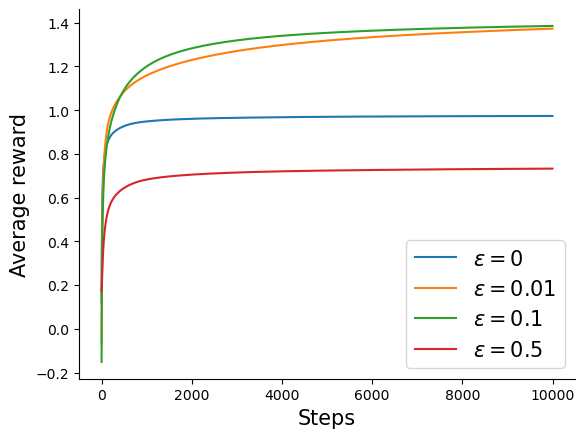

In [14]:
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel("Steps", fontsize=15)
plt.ylabel("Average reward", fontsize=15)

for key, value in data.items():
    epsilon = value["epsilon"]
    plt.plot(value["rewards"], label=f"$\epsilon={epsilon}$")
    
plt.legend(fontsize=15)

#### Average optimal action over time for several 10-armed bandit realizations

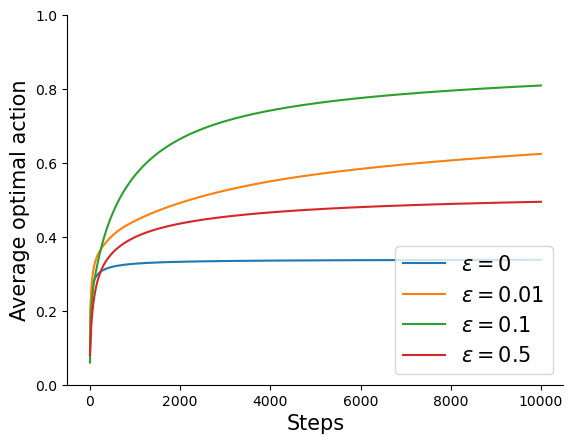

In [15]:
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel("Steps", fontsize=15)
plt.ylabel("Average optimal action", fontsize=15)
plt.ylim(bottom=0, top=None)

for key, value in data.items():
    epsilon = value["epsilon"]
    plt.plot(value["optimal_actions"], label=f"$\epsilon={epsilon}$")
    
plt.legend(loc="lower right", fontsize=15)

### Nonstationary Case

For the constant time step implementation, the update formula follows

$$Q_{n+1} \doteq Q_n+\alpha\left[R_n-Q_n\right]$$

By using a constant $\alpha$, recent rewards have a more consistent impact on the value estimates, which is advantageous in environments where reward probabilities are subject to change.

For the <i>$\epsilon$-greedy </i> case with $\epsilon=0.1$, let's compare the incremental time step algorithm against the constant time step one with $\alpha=0.1$ in a nonstationary environment. In this simulation, the means of the reward distributions evolve as random walks with zero mean and a standard deviation of 0.01, presenting a dynamic and changing environment for the algorithms.

In [16]:
rewards1, optimal_actions1 = sample_multiple_bandits(epsilon=0.1, alpha=None, stationary=False, steps=20000, n_samples=100) #Incremental time step
rewards2, optimal_actions2 = sample_multiple_bandits(epsilon=0.1, alpha=0.1,  stationary=False, steps=20000, n_samples=100) #Constant time step

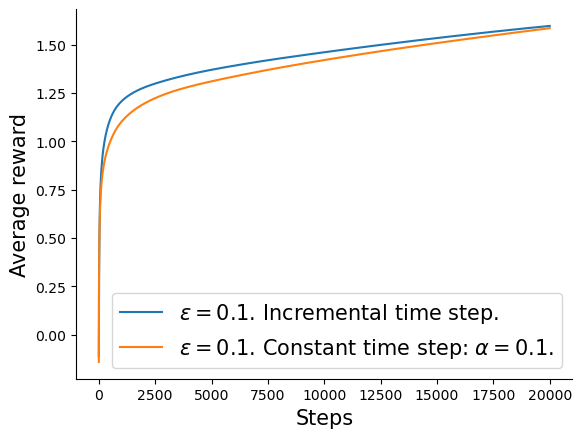

In [17]:
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel("Steps", fontsize=15)
plt.ylabel("Average reward", fontsize=15)

plt.plot(rewards1, label="$\epsilon=0.1$. Incremental time step.")
plt.plot(rewards2, label=r"$\epsilon=0.1$. Constant time step: $ \alpha=0.1 $.")
    
plt.legend(fontsize=15)

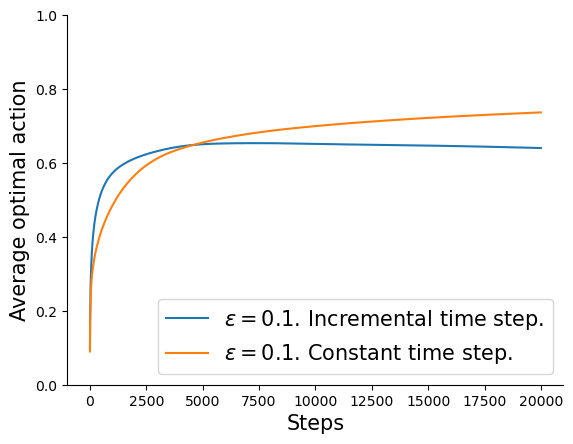

In [18]:
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel("Steps", fontsize=15)
plt.ylabel("Average optimal action", fontsize=15)
plt.ylim(bottom=0, top=None)

plt.plot(optimal_actions1, label="$\epsilon=0.1$. Incremental time step.")
plt.plot(optimal_actions2, label="$\epsilon=0.1$. Constant time step.")
    
plt.legend(loc="lower right", fontsize=15)

### Optimistic Initial Values

Rather than initializing the action-value estimates at zero $Q(a)=0$, we now adopt an optimistic initialization strategy by setting $Q(a)=5$ for all actions. This optimistic start encourages initial exploration, as the algorithm initially overestimates the value of all actions, prompting the exploration of various actions before converging to the optimal one.


Let's compare the <i>$\epsilon$-greedy </i> with $\epsilon=0.1$ against the <i> greedy </i> algorithm for the stationary case and step size $\alpha=0.1$.

In [19]:
rewards_epsilon1, optimal_actions1 = sample_multiple_bandits(epsilon=0.1, alpha=0.1, Q0=0, steps=10000, n_samples=100) # Nonoptimistic 
rewards_epsilon2, optimal_actions2 = sample_multiple_bandits(epsilon=0.0, alpha=0.1, Q0=5, steps=10000, n_samples=100) # Optimistic

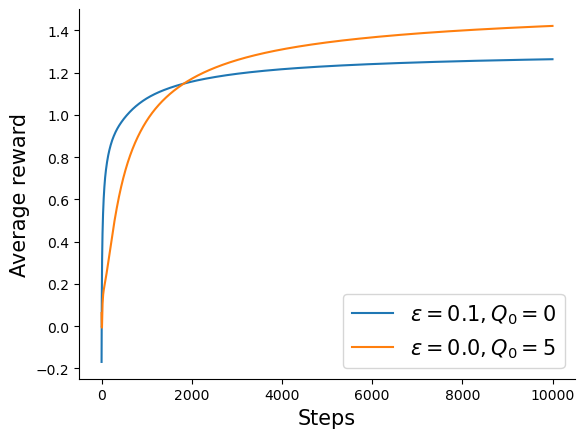

In [20]:
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel("Steps", fontsize=15)
plt.ylabel("Average reward", fontsize=15)

plt.plot(rewards_epsilon1, label="$\epsilon=0.1, Q_0 = 0$")
plt.plot(rewards_epsilon2, label="$\epsilon=0.0, Q_0 = 5$")
    
plt.legend(fontsize=15)

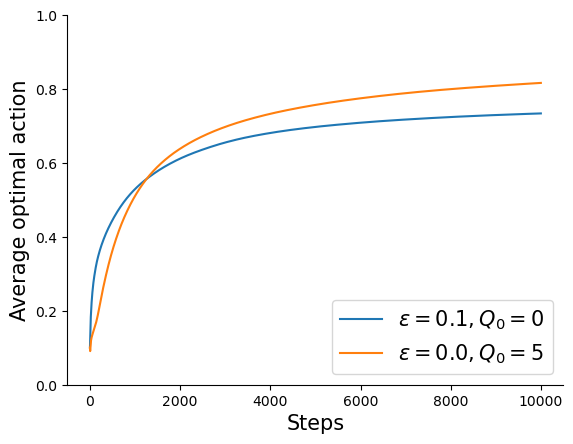

In [21]:
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel("Steps", fontsize=15)
plt.ylabel("Average optimal action", fontsize=15)
plt.ylim(bottom=0, top=None)

plt.plot(optimal_actions1, label="$\epsilon=0.1, Q_0 = 0$")
plt.plot(optimal_actions2, label="$\epsilon=0.0, Q_0 = 5$")
    
plt.legend(loc="lower right", fontsize=15)

### Upper-Confidence-Bound Action Selection

Upper Confidence Bound (UCB) prioritizes actions based on a balance between their estimated value and a factor encouraging exploration, as determined by

$$A_t \doteq \underset{a}{\arg \max }\left[Q_t(a)+c \sqrt{\frac{\ln t}{N_t(a)}}\right],$$

where $c$ controls the amount of exploration. 

Let's compare the <i>$\epsilon$-greedy </i> with $\epsilon=0.1$ against the UCB algorithm with $c=2$ for the stationary environment. 

In [22]:
rewards1, optimal_actions1 = sample_multiple_bandits(epsilon=0.1, action_selection="e-greedy", steps=10000, n_samples=100) #epsilon-greedy
rewards2, optimal_actions2 = sample_multiple_bandits(epsilon=0.0, action_selection="ucb", c=2, steps=10000, n_samples=100) #UCB

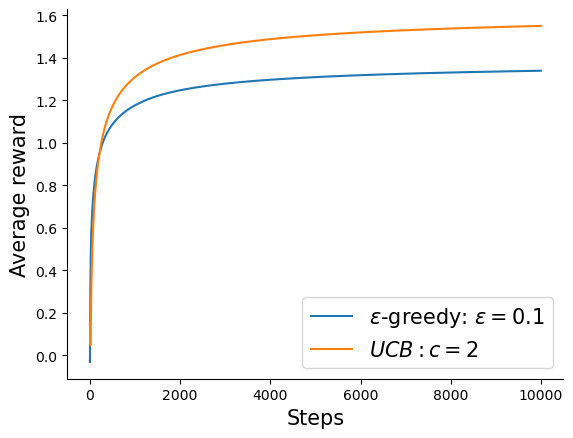

In [23]:
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel("Steps", fontsize=15)
plt.ylabel("Average reward", fontsize=15)

plt.plot(rewards1, label="$\epsilon$-greedy: $\epsilon=0.1$")
plt.plot(rewards2, label="$UCB: c=2 $")
    
plt.legend(fontsize=15)

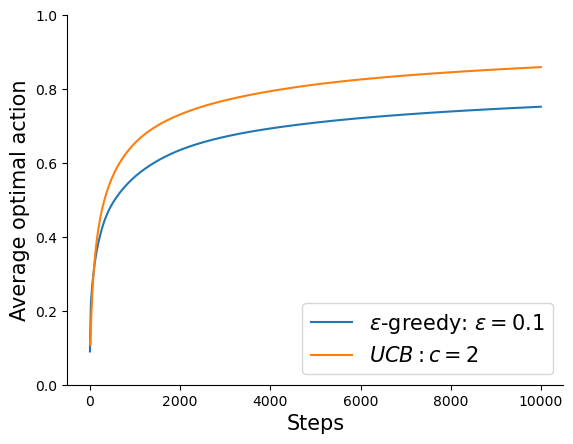

In [24]:
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel("Steps", fontsize=15)
plt.ylabel("Average optimal action", fontsize=15)
plt.ylim(bottom=0, top=None)

plt.plot(optimal_actions1, label="$\epsilon$-greedy: $\epsilon=0.1$")
plt.plot(optimal_actions2, label="$UCB: c=2 $")
    
plt.legend(loc="lower right", fontsize=15)